# Adversarial VAE detection on MNIST

## Method

The adversarial VAE detector is first trained on a batch of unlabeled but normal (*not adversarial*) data. The loss is however different from traditional VAE training and focuses on minimizing the KL-divergence between a classifier's predictions on the original and reconstructed data. When an adversarial instance is fed to the VAE, the KL-divergence between the predictions on the adversarial example and the reconstruction is large. The reconstruction does not contain the adversarial artefacts and has a very different prediction distribution. As a result, the adversarial instance is flagged.

## Dataset

traffic signs

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import zipfile
import logging

from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score

tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

In [3]:
from sklearn.metrics import confusion_matrix

# Load traffic signs data

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


### Show example

In [2]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

NameError: name 'X_train' is not defined

## Create and train traffic signs model

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [model_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/model_mnist/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/model_mnist my_dir
```

In [584]:
load_model = False

In [585]:
filepath = './model_mnist/'
if load_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #inputs = Input(shape=(X_train.shape[1:]))
    #x = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(inputs)
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    #
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    #
    #x = Flatten()(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #logits = Dense(10, name='logits')(x)
    #outputs = Activation('softmax', name='softmax')(logits)
    #model = Model(inputs=inputs, outputs=outputs)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam',
    #              metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=5,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    
    # save model
    save_tf_model(model, filepath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 29s 479us/sample - loss: 0.7179 - accuracy: 0.7336 - val_loss: 0.4625 - val_accuracy: 0.8348
Epoch 2/5
60000/60000 [==============================] - 31s 516us/sample - loss: 0.4610 - accuracy: 0.8346 - val_loss: 0.3741 - val_accuracy: 0.8668
Epoch 3/5
60000/60000 [==============================] - 35s 580us/sample - loss: 0.4112 - accuracy: 0.8520 - val_loss: 0.3517 - val_accuracy: 0.8752
Epoch 4/5
60000/60000 [==============================] - 32s 536us/sample - loss: 0.3808 - accuracy: 0.8618 - val_loss: 0.3265 - val_accuracy: 0.8828
Epoch 5/5
60000/60000 [==============================] - 33s 548us/sample - loss: 0.3572 - accuracy: 0.8711 - val_loss: 0.3160 - val_accuracy: 0.8812


In [586]:
# evaluate model
results = model.evaluate(X_val, y_val, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

NameError: name 'X_val' is not defined

In [587]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.3160 -- accuracy: 0.8812


In [588]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)          0   

In [589]:
probs = model(X_test).numpy()

In [590]:
probs.shape

(10000, 10)

In [591]:
probs.max(axis=1).mean()

0.8712808

## Train Adversarial VAE for MNIST

You can again either manually download the relevant files in the [ad_vae_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad_vae_mnist/) folder to e.g. the local directory ```my_dir``` or use ```gsutil```:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/ad_vae_mnist my_dir
```

In [592]:
load_adversarial_detector = False

In [593]:
#encoder_net = tf.keras.Sequential(
#    [
#        InputLayer(input_shape=(32, 32, 3)),
#        Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
#        #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25),
#        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25)
#    ]
#)

In [633]:
filepath = './ad_vae_mnist/'  # change to directory where model is downloaded
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = 100
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(28, 28, 1)),
          Conv2D(64, 2, strides=2, padding='same', activation='relu'),
          Conv2D(32, 2, strides=2, padding='same', activation='relu'),
          Flatten(),
          Dense(256, activation='relu')
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7*7*32, activation=tf.nn.relu),
          Reshape(target_shape=(7, 7, 32)),
          Conv2DTranspose(32, 2, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 2, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid')
      ])
    
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    


In [634]:
encoder_net.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 64)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          8224      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               401664    
Total params: 410,208
Trainable params: 410,208
Non-trainable params: 0
_________________________________________________________________


In [635]:
decoder_net.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1568)              158368    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 32)        4128      
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 64)        8256      
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 1)         577       
Total params: 171,329
Trainable params: 171,329
Non-trainable params: 0
_________________________________________________________________


In [636]:
if not load_adversarial_detector:
    # train
    ad.fit(X_train,
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=Adam(),
           epochs=2,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(ad, filepath)

938/938 [=] - 152s 162ms/step - loss: 0.0522


## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [637]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [638]:
nb_adv = 500
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_test[ids]
y_adv = y_test[ids]
print(X_to_adv.shape)

(500, 28, 28, 1)


In [639]:
X_adv = projected_gradient_descent(model_logits, ad, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

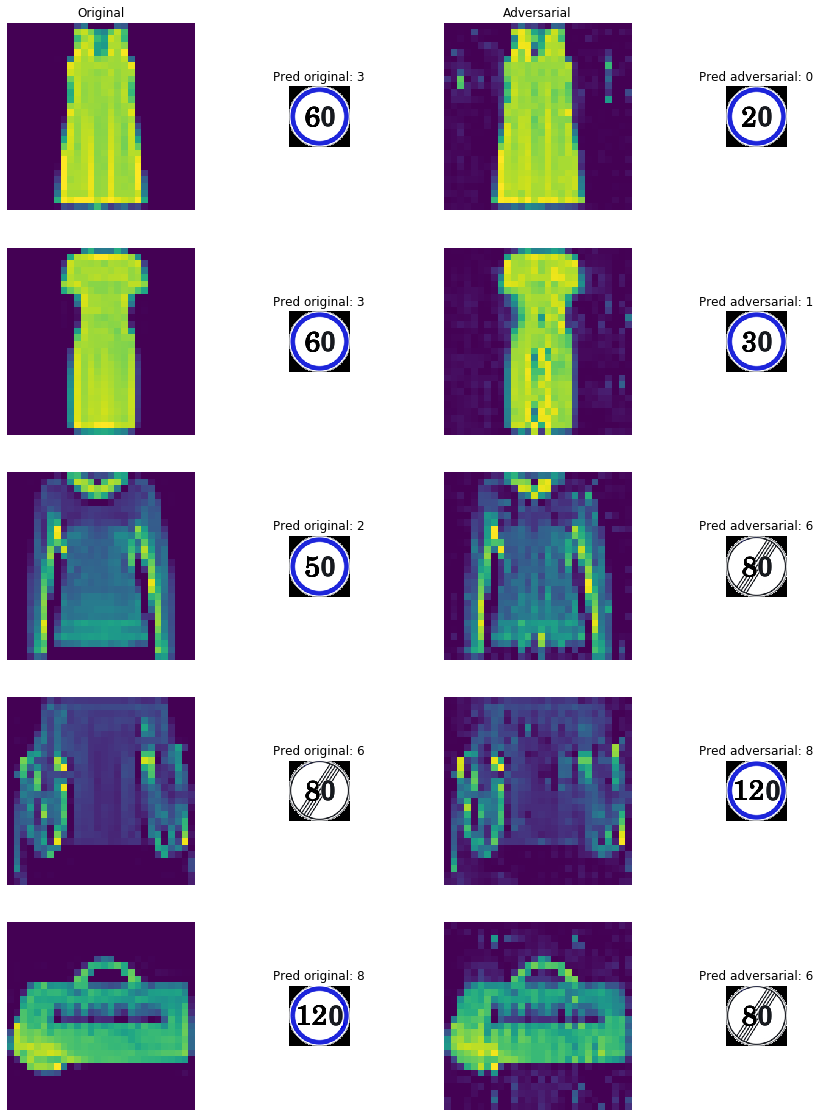

In [640]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

## Detect adversarial instances# Detect Advs

In [641]:
#X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
#X_adv = X_adv[(y_pred != y_pred_adv)]

In [642]:
X = np.concatenate([X_to_adv, X_adv], axis=0)
print(X.shape)

(1000, 28, 28, 1)


In [643]:
ad.infer_threshold(X_train[:2000], threshold_perc=95.)

In [644]:
ad_preds = ad.predict(X, return_instance_score=True)

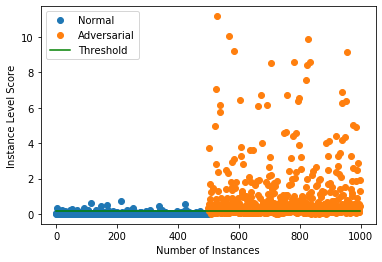

In [645]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

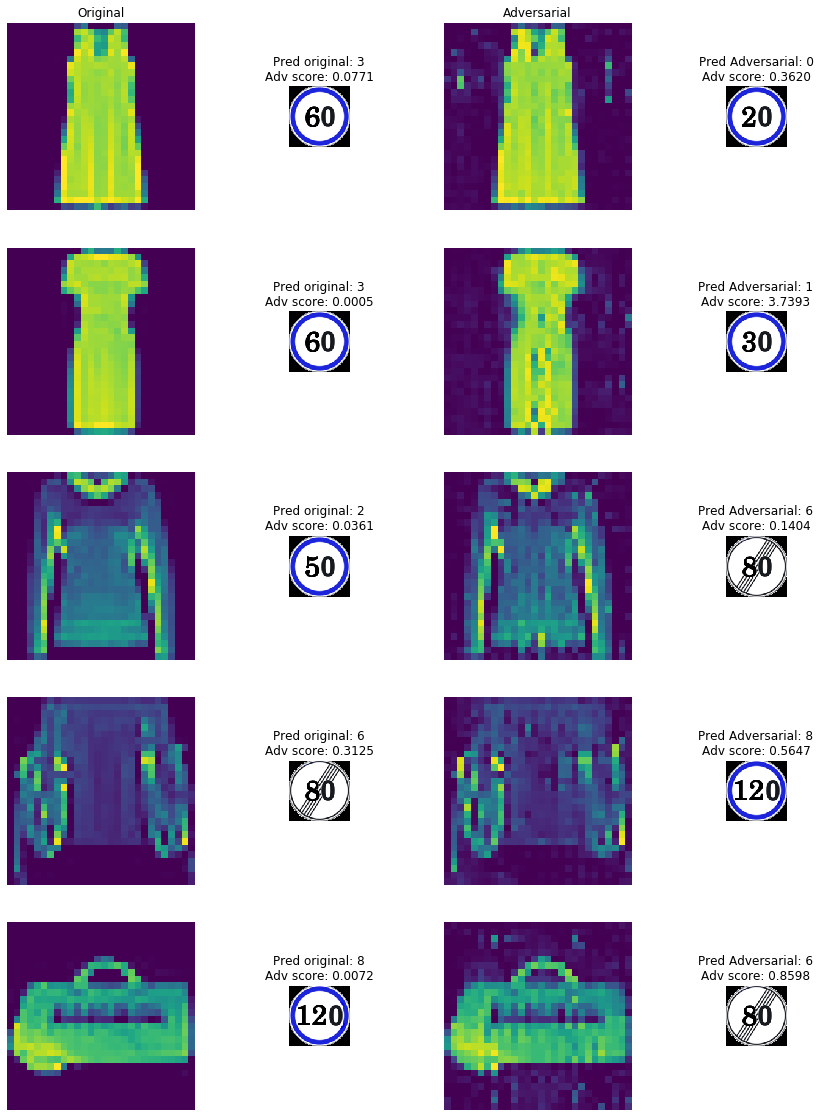

In [646]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred Adversarial: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Adversarial detection performances

In [647]:
kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [648]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(500,) (500,)
0.03919249 0.08796317
1.120003 1.7467687


In [649]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [650]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))

Adversarial detection accuracy: 0.825


In [651]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.7972190034762456


In [652]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad, preds_ad)

Adversarial detection confusion matrix:


array([[481,  19],
       [156, 344]])

In [653]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:100]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [654]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.9233333333333333


In [655]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.7604166666666666


In [656]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Adversarial detection confusion matrix:


array([[481,  19],
       [ 27,  73]])

In [657]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:10]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [658]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.9568627450980393


In [659]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.3888888888888889


In [660]:
print('Adversarial detection confusion matrix:')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Adversarial detection confusion matrix:


array([[481,  19],
       [  3,   7]])

## Curves

In [661]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [662]:
perm = np.random.permutation(range(len(kl_adv)))[:100]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [663]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

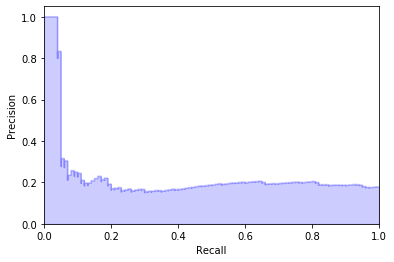

In [664]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

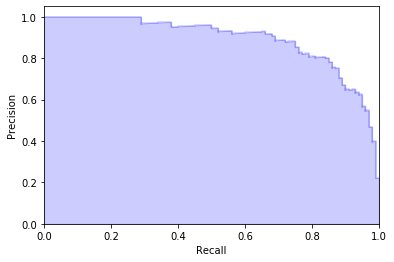

In [665]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Accuracy - f1 scores

In [666]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


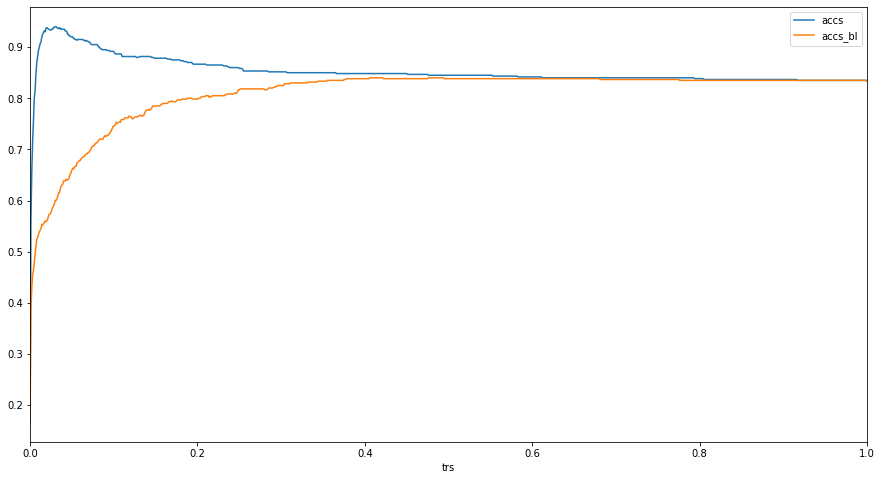

In [667]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


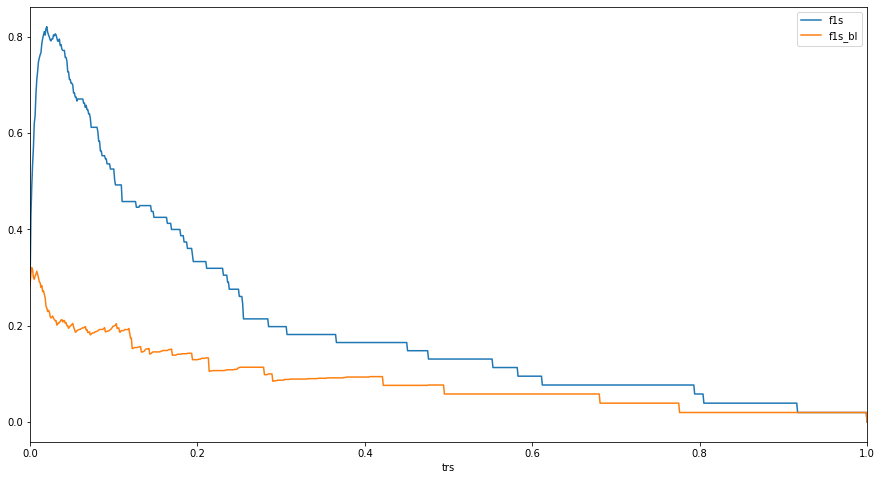

In [668]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [669]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.983360,0.140450,0.852464,0.202880,0.702983,0.070440,0.808087,0.083894
std,0.289108,0.076434,0.188909,0.034503,0.198326,0.349750,0.105879,0.067516,0.061759
min,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
25%,0.250000,1.000000,0.040000,0.840000,0.076923,0.272727,0.020000,0.816667,0.039216
50%,0.500000,1.000000,0.070000,0.845000,0.130841,1.000000,0.030000,0.835000,0.058252
75%,0.750000,1.000000,0.150000,0.853333,0.260870,1.000000,0.070000,0.838333,0.108527
max,1.000000,1.000000,1.000000,0.940000,0.821256,1.000000,1.000000,0.840000,0.320792


### Distributions

Vae detector


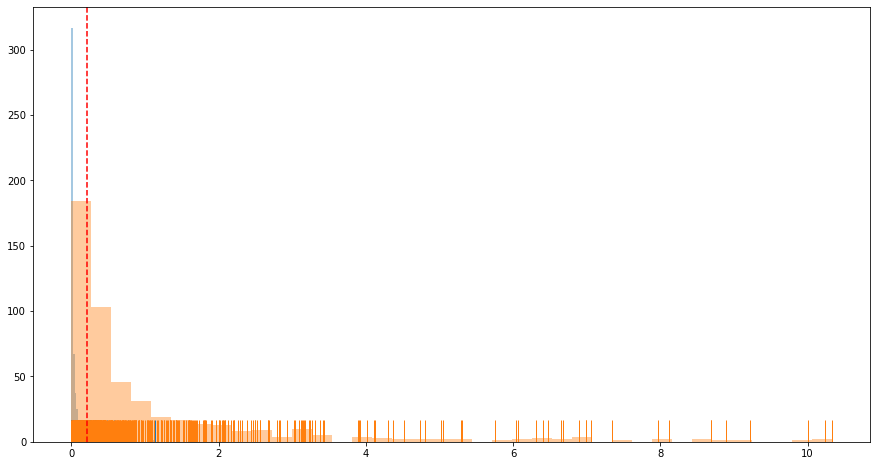

In [670]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


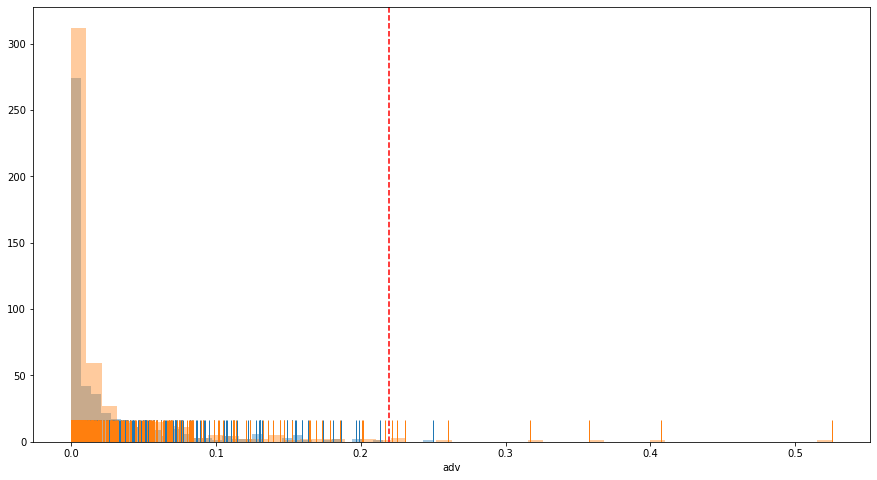

In [671]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)